torch.Size([1, 80, 128, 128])


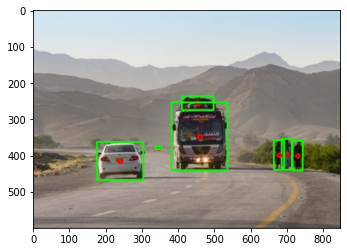

In [2]:
import torch
import torch.nn as nn
import numpy as np
import cv2

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt


def nms_by_maxpool(hm, wh, reg_xy, conf_T = 0.3, ksize = 3, stride = 1):
    maxpool = nn.MaxPool2d(ksize, stride = 1, padding=(ksize - 1) // 2) # Maxpool is 2d not 3d. No influence between classes.
    maxpooled_hm = maxpool(hm)  # multipe images   multiple classes
    hm_keep_mask = (hm == maxpooled_hm).bool() & (hm > conf_T) # [num_batch, num_classes, y, x] # hm_keep_mask includes all classes    
    
    kept_mask,_ = hm_keep_mask.max(1, keepdims = True) # Along class axis. As long as there is at least a 1 along class axis in kept_mask(y,x), the value should be 1.
    
    kept_hm = kept_mask * hm
    kept_wh = kept_mask * wh
    kept_regxy = kept_mask * reg_xy
    
    return kept_mask, kept_hm, kept_wh, kept_regxy
    

def preprocess(img):
    import numpy as np
    h, w, _ = img.shape
    scale   = min(512/h, 512/w)
    translation_w = -w*0.5*scale + 512*0.5
    translation_h = -h*0.5*scale + 512*0.5

    M = np.array([[scale, 0, translation_w],
                  [0, scale, translation_h]])

    affine_img = cv2.warpAffine(img, M, (512, 512))
    
    mean = np.array([0.408, 0.447, 0.470], dtype = np.float32)
    std = np.array([0.289, 0.274, 0.278], dtype = np.float32)

    norm_affine_img = (affine_img / 255. - mean) / std
    
    return norm_affine_img.transpose(2,0,1)[None], affine_img, M


def decode(output, image, affine_img, inv_M, dp_r=4.0, conf_T = 0.3):
    """
    dp_r: downsample_ratio
    image: warp affined image
    M : tansformation matrix
    """ 
    final_show = image.copy()
    show = affine_img.copy()
    src_h, src_w, _ = image.shape
    
    # 1. Three heads of the output
    hm = output["hm"].sigmoid_()
    print(hm.shape)
    wh = output["wh"]
    reg_xy = output["reg"]
    
    # 2. NMS
    _, kept_hm, kept_wh, kept_regxy = nms_by_maxpool(hm, wh, reg_xy, conf_T = 0.3, ksize = 3, stride = 1)
        # kept_hm [1x80x128x128]  kept_wh and kept_regxy [1x2x128x128]
    
    # 3. Draw bbox on warpaffined_img
    max_conf_mat, label_idx_mat = kept_hm[0].max(0) # One image. Do max func along axis class axis
    ys_,xs_ = torch.where(max_conf_mat>0)
    for y,x in torch.stack((ys_, xs_)).T:
        reg_x, reg_y = kept_regxy[0][0][y,x], kept_regxy[0][1][y,x]
        w, h         = dp_r *kept_wh[0][0][y,x],  dp_r*kept_wh[0][1][y,x]
        y,x = y.item(), x.item()
        y_affine, x_affine = int(dp_r*(y + reg_y)), int(dp_r*(x + reg_x)) 
        left,right,top,bottom = \
                                int(x_affine - w/2), int(x_affine + w/2), \
                                int(y_affine - h/2), int(y_affine + h/2)


        cv2.circle(show, (x_affine, y_affine), radius=3, color=(0,0,255), thickness=2)
        cv2.rectangle(show,(left,top),(right,bottom),color = (0,255,0), thickness = 2)
    
    # 4. let the bbox back on the normal image
    cv2.warpAffine(show, inv_M[:2,:], (src_w, src_h), final_show)
    
    return final_show

    


image = cv2.imread("truck_and_person.jpg")
output_tensor = torch.load("model_output", map_location=torch.device('cpu')) 

_, affine_img, M = preprocess(image)

inv_M = np.linalg.inv(np.concatenate((M, np.array([[0,0,1.0]])),axis = 0))


visual_out = decode(output_tensor, image, affine_img, inv_M)
    
plt.imshow(visual_out[...,::-1])



# plt.imshow(kept_mask[0][0]) # kept_mask  # don't care class but obj location
# plt.imshow(kept_hm[0][0])   # show human
# plt.imshow(kept_wh[0][0])     # show w for the objs detected
# plt.imshow(kept_regxy[0][0]) # show regx for the objs detected
# plt.imshow(visual_out[...,::-1])


